# basic imports

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow
import glob
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf 
from tensorflow.keras import layers
!pip install --quiet vit-keras
from vit_keras import vit
from tensorflow.keras.applications.resnet50 import ResNet50

# Reading Data

In [2]:
#ucm
# train_data=pd.read_csv("/kaggle/input/satelite-csv/train.csv")
# train_data['File']=train_data['File'].apply(lambda x : '/kaggle/input/satelite-images/Images/'+x)
# test_data=pd.read_csv("/kaggle/input/satelite-csv/test.csv")
# test_data['File']=test_data['File'].apply(lambda x : '/kaggle/input/satelite-images/Images/'+x)

In [3]:
# rsscn7
# train_data=pd.read_csv("/kaggle/input/rsscn7-dataset/gamma-correct/train.csv")
# train_data['File']=train_data['File'].apply(lambda x : '/kaggle/input/rsscn7-dataset/gamma-correct/'+x)
# test_data=pd.read_csv("/kaggle/input/rsscn7-dataset/gamma-correct/test.csv")
# test_data['File']=test_data['File'].apply(lambda x : '/kaggle/input/rsscn7-dataset/gamma-correct/'+x)

In [4]:
#msrsi
train_data=pd.read_csv("/kaggle/input/msrsi-dataset/MSRSI/train_df.csv")
train_data['File']=train_data['File'].apply(lambda x : '/kaggle/input/msrsi-dataset/MSRSI/'+x)
test_data=pd.read_csv("/kaggle/input/msrsi-dataset/MSRSI/test_df.csv")
test_data['File']=test_data['File'].apply(lambda x : '/kaggle/input/msrsi-dataset/MSRSI/'+x)

In [5]:
train_data=train_data.sample(frac=1)
train_data

,File,class_
9388,/kaggle/input/msrsi-dataset/MSRSI/CircularFarm...,CircularFarmland
22510,/kaggle/input/msrsi-dataset/MSRSI/Bridge/Bridg...,Bridge
23934,/kaggle/input/msrsi-dataset/MSRSI/DenseResiden...,DenseResidential
8090,/kaggle/input/msrsi-dataset/MSRSI/IndustrialAr...,IndustrialArea
8560,/kaggle/input/msrsi-dataset/MSRSI/SolarPanel/S...,SolarPanel
...,...,...
21097,/kaggle/input/msrsi-dataset/MSRSI/Overpass/Ove...,Overpass
22023,/kaggle/input/msrsi-dataset/MSRSI/River/River_...,River
22313,/kaggle/input/msrsi-dataset/MSRSI/Desert/Deser...,Desert
20569,/kaggle/input/msrsi-dataset/MSRSI/Airport/Airp...,Airport


In [6]:
SIZE=448
size = [SIZE, SIZE ,3]

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=.1,
    fill_mode="nearest",
)
batch_size=64

In [8]:
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='File',
    y_col='class_',
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)
valid_images = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='File',
    y_col='class_',
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 21600 validated image filenames belonging to 15 classes.
Found 2400 validated image filenames belonging to 15 classes.


# freezing nescessary pararametres

In [9]:
import tensorflow_hub as hub

In [10]:
def get_from_hub(model_url):
    inputs = tf.keras.Input((batch_size,SIZE, SIZE, 3))
    hub_module = hub.KerasLayer(model_url,trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [11]:
def name_and_freeze(model,name=""):
    for layer in model.layers[:]:
      layer.trainable = False
    for layer in model.layers:
        layer._name = layer.name + str(name)
    

In [12]:
def se_block(inputs):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=len(train_images.class_indices.keys()), activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [13]:
def dilation_block(inputs,dilation_rates):
    outputs = []
    for dilation_rate in dilation_rates:
        x = tf.keras.layers.Conv2D(filters=len(train_images.class_indices.keys()), kernel_size=3, strides=1, padding="same", dilation_rate=dilation_rate)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        outputs.append(x)
    x = tf.keras.layers.Concatenate(axis=-1)(outputs)
    return x

# Importing Vit

In [14]:
vit_big = vit.vit_b32(
        image_size = SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        )

353263616/353253686 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 14, 14
  UserWarning,


In [15]:
# vit_large = vit.vit_l32(
#         image_size = SIZE,
#         activation = 'softmax',
#         pretrained = True,
#         include_top = False,
#         pretrained_top = False,
#         )

#  Fine-tuning vit

In [16]:
# name_and_freeze(vit_large,'vit_large_')
name_and_freeze(vit_big,'vit_big_')

In [17]:
from tensorflow.keras import regularizers
x =vit_big.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x_vit_big = Dense(128, activation='relu')(x)

# x =vit_large.output
# x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
# x = Dense(32, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
# x=Dense(256,activation='relu')(x)
# x_vit_large = Dense(128, activation='relu')(x)

# importing cnn models

In [18]:
# resnet152= tf.keras.applications.ResNet152V2(input_shape=size,include_top=False, weights='imagenet',)
# mobilenet= tf.keras.applications.MobileNetV3Large(input_shape=size,include_top=False, weights='imagenet')
xception= tf.keras.applications.Xception(input_shape=size,include_top=False, weights='imagenet')
# effecientnet= tf.keras.applications.EfficientNetB7(input_shape=size,include_top=False, weights='imagenet')
# densenet=tf.keras.applications.DenseNet121(input_shape=size,include_top=False, weights='imagenet')
# incepresnet=tf.keras.applications.InceptionResNetV2(input_shape=size,include_top=False, weights='imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [19]:
# print(xception.output)
# print(resnet152.output)
# print(mobilenet.output)
# print(effecientnet.output)
# print(densenet.output)
# print(incepresnet.output)

In [20]:
# name_and_freeze(resnet152,'resnet152_')
# name_and_freeze(mobilenet,'mobilenet_')
name_and_freeze(xception,'xception_')
# name_and_freeze(effecientnet,'effecientnet_')
# name_and_freeze(densenet,'densenet_')
# name_and_freeze(incepresnet,'incepResnet_')

In [21]:
def get_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(dilation_block(base_model.output,[2,3,5,7])))
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dense(256,activation='relu')(x)
    return Dense(128,activation='relu')(x)

# fine tuning CNN models

In [22]:
# x_resnet152v2=get_model(resnet152)
x_xception=get_model(xception)
# x_mobilenet=get_model(mobilenet)
# x_incepresnet=get_model(incepresnet)
# x_effecientnet=get_model(effecientnet)
# x_densenet=get_model(densenet)

# constructing full model

In [23]:
from tensorflow.keras.layers import concatenate
concatenated = concatenate([x_xception, x_vit_big])
bigmodel_prediction = Dense(len(train_images.class_indices), activation='softmax')(concatenated)
model = Model([xception.input, vit_big.input], bigmodel_prediction) 
from tensorflow.keras.utils import plot_model

In [24]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 1866894 non trainable parametres: 108431384


# custom generator

In [25]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]

# training model

In [26]:
model.compile(loss="categorical_crossentropy",optimizer=tf.optimizers.Adam(),metrics=['accuracy'])

In [27]:
batch_size=64
history = model.fit(
    generator_two_img(train_images),
    validation_data=generator_two_img(valid_images),
    validation_steps=valid_images.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_images.n//batch_size,
    batch_size=batch_size,
    epochs=20,
)


Epoch 1/20
337/337 [==============================] - 1451s 4s/step - loss: 2.5097 - accuracy: 0.8271 - val_loss: 0.8958 - val_accuracy: 0.8193
Epoch 2/20
337/337 [==============================] - 1304s 4s/step - loss: 0.6599 - accuracy: 0.8781 - val_loss: 0.6325 - val_accuracy: 0.8704
Epoch 3/20
337/337 [==============================] - 1279s 4s/step - loss: 0.5421 - accuracy: 0.8941 - val_loss: 0.5696 - val_accuracy: 0.8868
Epoch 4/20
337/337 [==============================] - 1305s 4s/step - loss: 0.5003 - accuracy: 0.9004 - val_loss: 0.5000 - val_accuracy: 0.9003
Epoch 5/20
337/337 [==============================] - 1299s 4s/step - loss: 0.4633 - accuracy: 0.9061 - val_loss: 0.4650 - val_accuracy: 0.9012
Epoch 6/20
337/337 [==============================] - 1289s 4s/step - loss: 0.4429 - accuracy: 0.9098 - val_loss: 0.4705 - val_accuracy: 0.9037
Epoch 7/20
337/337 [==============================] - 1294s 4s/step - loss: 0.4381 - accuracy: 0.9142 - val_loss: 0.4421 - val_accuracy:

In [28]:
model.save('1vit1cnnxception.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# performance evaluation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.


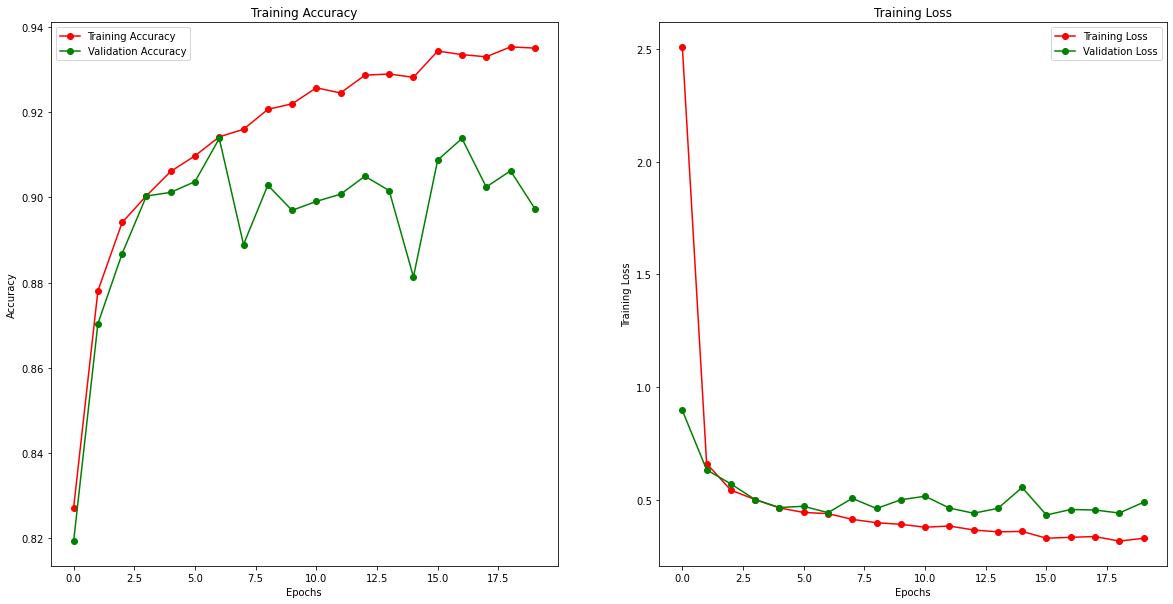

In [29]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

In [30]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='File',
    y_col='class_',
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 6000 validated image filenames belonging to 15 classes.


In [31]:
class_=train_images.class_indices.keys()

In [32]:
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break

In [33]:
from sklearn.metrics import accuracy_score
proba=model.predict(prediction_generator(test_images))
predicted = np.argmax(proba,axis=1)
true=test_images.labels
accuracy_score(predicted, true)

0.8975

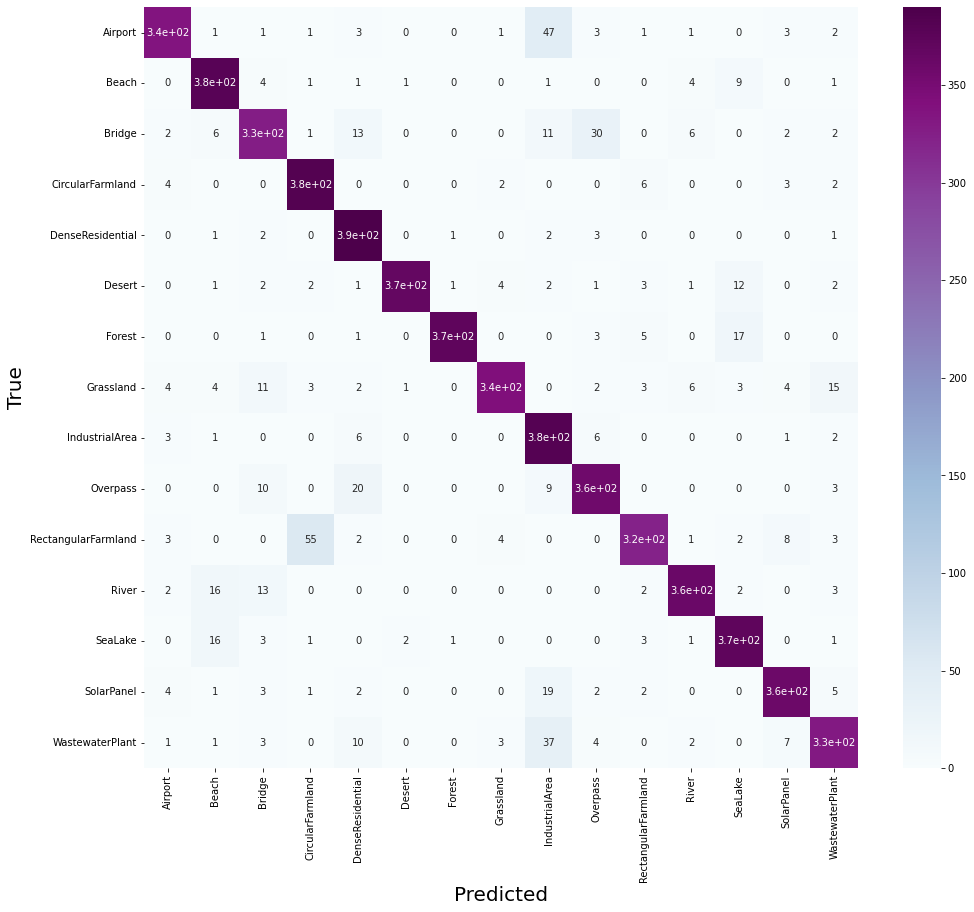

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

# ROC

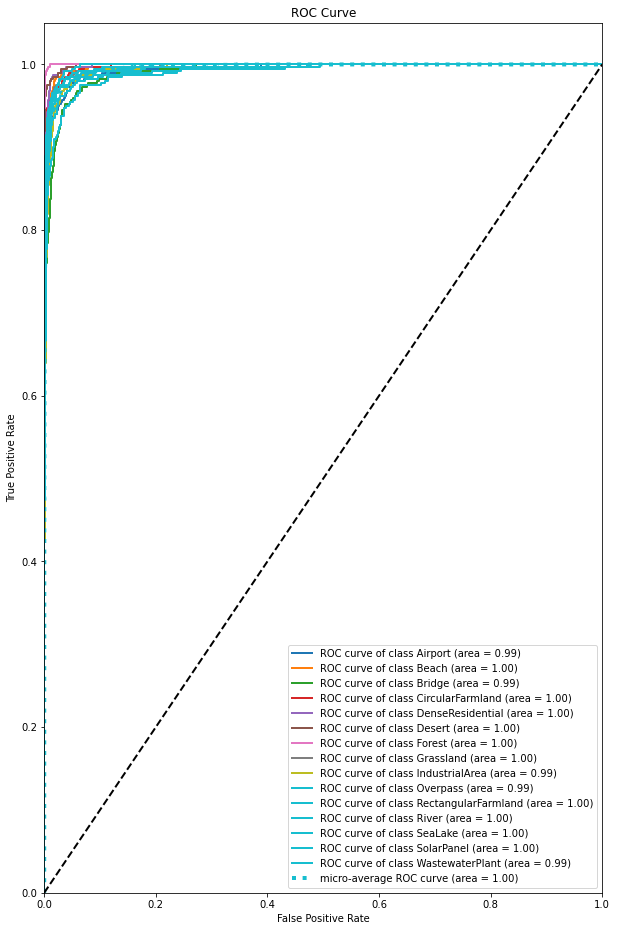

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm
n=len(true)
dim=max(true)+1
result=[]
for i in true:
    result.append([0 for i in range(dim)])
    result[len(result)-1][i]=1
    
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =len(test_images.class_indices.keys())
y_test=np.array(result)
y_pred=np.array(proba)
fpr = dict()
tpr = dict()
roc_auc = dict()

rev={}
for i in class_:
    rev[train_images.class_indices[i]]=i


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')


cmap = cm.get_cmap('tab10')

# Plot the ROC curve for each class and micro-average with automatic color selection
plt.figure(figsize=(10,16))
lw = 2
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(rev[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# AUC

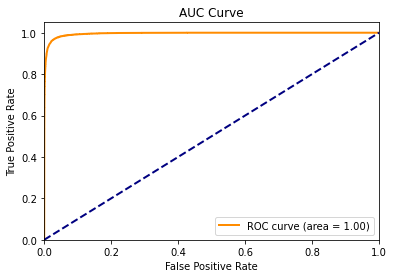

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true=y_test
y_score=y_pred
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right")
plt.show()